# COMP5318: Assignment 2 - Tree Ensemble Algorithms

#### Members
*   Jesse Narvasa
*   Mimansa Rana
*   Stephanie Shen


## Library import, static variables setup

In [1]:
# Import Libraries

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Static Variables

# Dataset to use
# Can be original or true_ratio - check switch_dataset function below
DATASET = 'original'

INPUT_DIR = 'drive/My Drive/COMP5318 Assignment 2/data/input/Img/GoodImg/Bmp'
OUTPUT_DIR  = 'drive/My Drive/COMP5318 Assignment 2/data/output'

# Please leave these as empty strings, use the function below to set the actual filenames
IMAGES_FILE = ''
IMAGES_MASKED_FILE = ''
LABELS_FILE = ''

def switch_dataset(dataset=DATASET):
    '''
    Function used to switch the filename for the global variables IMAGES_FILE, IMAGES_MASKED_FILE, LABELS_FILE
    INPUT: dataset string: original, true_ratio
    OUTPUT: Returns None
    '''

    global IMAGES_FILE, IMAGES_MASKED_FILE, LABELS_FILE
    if dataset == 'original':
        IMAGES_FILE = 'images.npy'
        IMAGES_MASKED_FILE = 'images_masked.npy'
        LABELS_FILE = 'labels.npy'
    elif dataset == 'true_ratio':
        IMAGES_FILE = 'images_true_ratio.npy'
        IMAGES_MASKED_FILE = 'images_masked_true_ratio.npy'
        LABELS_FILE = 'labels_true_ratio.npy'

    return

switch_dataset(DATASET)

RESIZE_DIM = (48,48)
FOLDER_CLASS_MAPPING = {
    'Sample001': 0,
    'Sample002': 1,
    'Sample003': 2,
    'Sample004': 3,
    'Sample005': 4,
    'Sample006': 5,
    'Sample007': 6,
    'Sample008': 7,
    'Sample009': 8,
    'Sample010': 9,
    'Sample011': 10,
    'Sample012': 11,
    'Sample013': 12,
    'Sample014': 13,
    'Sample015': 14,
    'Sample016': 15,
    'Sample017': 16,
    'Sample018': 17,
    'Sample019': 18,
    'Sample020': 19,
    'Sample021': 20,
    'Sample022': 21,
    'Sample023': 22,
    'Sample024': 23,
    'Sample025': 24,
    'Sample026': 25,
    'Sample027': 26,
    'Sample028': 27,
    'Sample029': 28,
    'Sample030': 29,
    'Sample031': 30,
    'Sample032': 31,
    'Sample033': 32,
    'Sample034': 33,
    'Sample035': 34,
    'Sample036': 35,
    'Sample037': 36,
    'Sample038': 37,
    'Sample039': 38,
    'Sample040': 39,
    'Sample041': 40,
    'Sample042': 41,
    'Sample043': 42,
    'Sample044': 43,
    'Sample045': 44,
    'Sample046': 45,
    'Sample047': 46,
    'Sample048': 47,
    'Sample049': 48,
    'Sample050': 49,
    'Sample051': 50,
    'Sample052': 51,
    'Sample053': 52,
    'Sample054': 53,
    'Sample055': 54,
    'Sample056': 55,
    'Sample057': 56,
    'Sample058': 57,
    'Sample059': 58,
    'Sample060': 59,
    'Sample061': 60,
    'Sample062': 61
}

## Generate Images Dataset

In [ ]:
def generate_image_dataset(keep_aspect_ratio=False):
    '''
    Generates Numpy array out of input Chars74K dataset
    INPUT: (optional) keep_aspect_ratio determines if you want to retain the aspect ratio of the images provided
    OUTPUT: images in Numpy array format,
        masked images in Numpy array format,
        labes of the images in Numpy array format
    '''

    images, images_masked, labels = [], [], []

    for folder in sorted(os.listdir(INPUT_DIR)):
        print(folder)

        # Ignore .DS_Store directory for Macs
        if folder.startswith('.'):
            continue

        class_label = FOLDER_CLASS_MAPPING[folder]
        image_files = os.listdir(os.path.join(INPUT_DIR, folder))
        
        for file in image_files:
            if not file.endswith('.png'):
                continue
                
            # load image
            img = Image.open(os.path.join(INPUT_DIR, folder, file))
            img = img.convert('L')
            
            # Load mask
            mask = Image.open(os.path.join(os.path.split(INPUT_DIR)[0], 'Msk', folder, file))

            if keep_aspect_ratio:
                # Creating thumbnail of specific dimension
                img.thumbnail(RESIZE_DIM, Image.ANTIALIAS)
                mask.thumbnail(RESIZE_DIM, Image.ANTIALIAS)

                # Check the image dimensions
                w, h = img.size

                img_resized = Image.new('L', RESIZE_DIM, color=0)
                mask_resized = Image.new('L', RESIZE_DIM, color=0)

                img_resized.paste(img, ((RESIZE_DIM[0] - w) // 2, (RESIZE_DIM[1] - h) // 2))
                mask_resized.paste(mask, (int((RESIZE_DIM[0] - w) / 2), int((RESIZE_DIM[1] - h) / 2)))
            
            else:
                # Resizing both img and mask
                img_resized = img.resize(RESIZE_DIM)
                mask_resized = mask.resize(RESIZE_DIM)
                
            # transforming the image into a Numpy array
            img_resized = np.asarray(img_resized).reshape((1,RESIZE_DIM[0]**2))
            mask_resized = np.asarray(mask_resized).reshape((1,RESIZE_DIM[0]**2))
            
            img_masked = img_resized.copy()
            img_masked[mask_resized==0] = 0
            
            images.append(img_resized)
            images_masked.append(img_masked)
            labels.append(class_label)
            #print(file)

    images = np.concatenate(images, axis=0)
    images_masked = np.concatenate(images_masked, axis=0)
    labels = np.array(labels)

    return images, images_masked, labels

In [ ]:
# Generate the "stretched" dataset
switch_dataset('original')
images, images_masked, labels = generate_image_dataset(keep_aspect_ratio=False)

# Checking the shape after the image extraction
print(f'Raw images shape: {images.shape}')
print(f'Masked images shape: {images_masked.shape}')
print(f'Labels shape: {labels.shape}')

# Saving the array representation of the images
np.save(os.path.join(OUTPUT_DIR, IMAGES_FILE), images)
np.save(os.path.join(OUTPUT_DIR, IMAGES_MASKED_FILE), images_masked)
np.save(os.path.join(OUTPUT_DIR, LABELS_FILE), labels)

# Checking the shape of the saved data, ensuring that it's the same shape as what we had before - for verification
print((np.load(os.path.join(OUTPUT_DIR, IMAGES_FILE))).shape)
print((np.load(os.path.join(OUTPUT_DIR, IMAGES_MASKED_FILE))).shape)
print((np.load(os.path.join(OUTPUT_DIR, LABELS_FILE))).shape)


# Generate the "true aspect ratio" dataset
switch_dataset('true_ratio')
images, images_masked, labels = generate_image_dataset(keep_aspect_ratio=True)

# Checking the shape after the image extraction
print(f'Raw images shape: {images.shape}')
print(f'Masked images shape: {images_masked.shape}')
print(f'Labels shape: {labels.shape}')

# Saving the array representation of the images
np.save(os.path.join(OUTPUT_DIR, IMAGES_FILE), images)
np.save(os.path.join(OUTPUT_DIR, IMAGES_MASKED_FILE), images_masked)
np.save(os.path.join(OUTPUT_DIR, LABELS_FILE), labels)

# Checking the shape of the saved data, ensuring that it's the same shape as what we had before - for verification
print((np.load(os.path.join(OUTPUT_DIR, IMAGES_FILE))).shape)
print((np.load(os.path.join(OUTPUT_DIR, IMAGES_MASKED_FILE))).shape)
print((np.load(os.path.join(OUTPUT_DIR, LABELS_FILE))).shape)

## Data Exploration

In [3]:
def reload_data(dataset=DATASET):
    '''
    Function used to reload the dataset based on the dataset that's entered
    INPUT: Dataset to be loaded, accepted values are 'original', true_ratio' but will default to the value DATASET of dataset variable if none entered
    OUTPUT: returns images, images_masked, labels Numpy arrays
    '''

    switch_dataset(dataset)

    # Loading the dataset from the saved numpy object
    images = np.load(os.path.join(OUTPUT_DIR, IMAGES_FILE))
    images_masked = np.load(os.path.join(OUTPUT_DIR, IMAGES_MASKED_FILE))
    labels = np.load(os.path.join(OUTPUT_DIR, LABELS_FILE))

    # Verifying the shape
    print(f'Raw images shape: {images.shape}')
    print(f'Masked images shape: {images_masked.shape}')
    print(f'Labels shape: {labels.shape}')
    print(f'Loading from {IMAGES_FILE, IMAGES_MASKED_FILE, LABELS_FILE}')

    return images, images_masked, labels

In [6]:
images, images_masked, labels = reload_data('original')

Raw images shape: (7705, 2304)
Masked images shape: (7705, 2304)
Labels shape: (7705,)
Loading from ('images.npy', 'images_masked.npy', 'labels.npy')


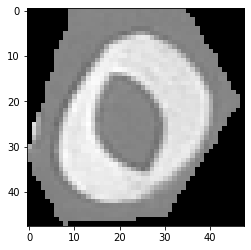

In [7]:
# Verifying the quality of images to be used by our algorithms, if it's what we expect
# Important observation here is that Google Colab does not actually go through the file names sequentially, as you would find in Jupiter notebook.
TESTING_IMAGE = 11

images_square = images_masked.reshape((images_masked.shape[0],RESIZE_DIM[0], RESIZE_DIM[0]))
plt.imshow(images_square[TESTING_IMAGE], cmap=plt.get_cmap('gray'))
plt.show()

## Model Selection

### Without PCA applied - Original Dataset

In [8]:
# Ensuring we are loading the correct data
images, images_masked, labels = reload_data('original')

# Running the split on the masked images
X_train, X_test, y_train, y_test = train_test_split(images_masked, labels, test_size=0.25, shuffle=True, stratify=labels)

Raw images shape: (7705, 2304)
Masked images shape: (7705, 2304)
Labels shape: (7705,)
Loading from ('images.npy', 'images_masked.npy', 'labels.npy')


#### Random Forest Classifier

This is found to be the best performing Random Forest Classifier setup, as well as the best tree ensemble algorithm when compared against the best result of XGBoost

In [9]:
rfc = RandomForestClassifier(
    max_depth = None,
    verbose = 1,
    class_weight = 'balanced',
    criterion = 'entropy',
    min_impurity_decrease = 0,
    min_samples_split = 5,
    n_estimators = 250
)

# Setting up the pipeline for RandomForest
rfc_pipe = Pipeline([('rfc', rfc)])

cv_results = cross_validate(rfc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5481184746301416


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 19.6min finished


#### XGBoostClassifier

This is found to be the best performing XGBoost setup, however is no match for Random Forest

In [10]:
xgc = xgb.XGBClassifier(
    objective = 'multi:softmax', # softmax because we only want the one with the highest proba
    missing = None, # important to ensure optimal performance
    subsample = 0.75, # so we are using slightly different dataset for each of the boosting rounds
    tree_method = 'gpu_hist', # to enable GPU implementation of XGBoost, for optimal calculations
    learning_rate = 0.1,
    max_depth = 7,
    min_child_weight = 1
)

xgc_pipe = Pipeline([('xgc', xgc)])

cv_results = cross_validate(xgc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.4984453053318381


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.8min finished


### Without PCA applied - True Ratio Dataset

In [11]:
# Ensuring we are loading the correct data
images, images_masked, labels = reload_data('true_ratio')

# Running the split on the masked images
X_train, X_test, y_train, y_test = train_test_split(images_masked, labels, test_size=0.25, shuffle=True, stratify=labels)

Raw images shape: (7705, 2304)
Masked images shape: (7705, 2304)
Labels shape: (7705,)
Loading from ('images_true_ratio.npy', 'images_masked_true_ratio.npy', 'labels_true_ratio.npy')


#### Random Forest Classifier

In [12]:
rfc = RandomForestClassifier(
    max_depth = None,
    verbose = 1,
    class_weight = None,
    criterion = 'gini',
    min_impurity_decrease = 0,
    min_samples_split = 2,
    n_estimators = 250
)

# Setting up the pipeline for RandomForest
rfc_pipe = Pipeline([('rfc', rfc)])

cv_results = cross_validate(rfc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.442887084490234


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.9min finished


#### XGBoostClassifier

In [13]:
xgc = xgb.XGBClassifier(
    objective = 'multi:softmax', # softmax because we only want the one with the highest proba
    missing = None, # important to ensure optimal performance
    subsample = 0.75, # so we are using slightly different dataset for each of the boosting rounds
    tree_method = 'gpu_hist', # to enable GPU implementation of XGBoost, for optimal calculations
    learning_rate = 0.05,
    max_depth = 9,
    min_child_weight = 1
)

xgc_pipe = Pipeline([('xgc', xgc)])

cv_results = cross_validate(xgc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.4247143979418661


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.1min finished


### With PCA - Original Dataset

In [14]:
std_scaler = StandardScaler()
pca = PCA(n_components = 0.95, svd_solver = 'full')

# Ensuring we are loading the correct data
images, images_masked, labels = reload_data('original')

# Running the split on the masked images
X_train, X_test, y_train, y_test = train_test_split(images_masked, labels, test_size=0.25, shuffle=True, stratify=labels)

Raw images shape: (7705, 2304)
Masked images shape: (7705, 2304)
Labels shape: (7705,)
Loading from ('images.npy', 'images_masked.npy', 'labels.npy')


#### Random Forest Classifier

In [15]:
rfc = RandomForestClassifier(
    max_depth = None,
    verbose = 1,
    class_weight = None,
    criterion = 'entropy',
    min_impurity_decrease = 0,
    min_samples_split = 3,
    n_estimators = 250
)

# Setting up the pipeline for RandomForest
rfc_pipe = Pipeline([('std', std_scaler),
                     ('pca', pca),
                     ('rfc', rfc)])

cv_results = cross_validate(rfc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.4376892769545376


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 18.3min finished


#### XGBoostClassifier

In [16]:
xgc = xgb.XGBClassifier(
    objective = 'multi:softmax', # softmax because we only want the one with the highest proba
    missing = None, # important to ensure optimal performance
    subsample = 0.75, # so we are using slightly different dataset for each of the boosting rounds
    tree_method = 'gpu_hist', # to enable GPU implementation of XGBoost, for optimal calculations
    learning_rate = 0.05,
    max_depth = 9,
    min_child_weight = 1
)

xgc_pipe = Pipeline([('std', std_scaler),
                     ('pca', pca),
                     ('xgc', xgc)])

cv_results = cross_validate(xgc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.4300837166347832


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.4min finished


### With PCA - True Ratio Dataset

In [17]:
std_scaler = StandardScaler()
pca = PCA(n_components = 0.95, svd_solver = 'full')

# Ensuring we are loading the correct data
images, images_masked, labels = reload_data('true_ratio')

# Running the split on the masked images
X_train, X_test, y_train, y_test = train_test_split(images_masked, labels, test_size=0.25, shuffle=True, stratify=labels)

Raw images shape: (7705, 2304)
Masked images shape: (7705, 2304)
Labels shape: (7705,)
Loading from ('images_true_ratio.npy', 'images_masked_true_ratio.npy', 'labels_true_ratio.npy')


#### Random Forest Classifier

In [18]:
rfc = RandomForestClassifier(
    max_depth = None,
    verbose = 1,
    class_weight = None,
    criterion = 'gini',
    min_impurity_decrease = 0,
    min_samples_split = 4,
    n_estimators = 250
)

# Setting up the pipeline for RandomForest
rfc_pipe = Pipeline([('std', std_scaler),
                     ('pca', pca),
                     ('rfc', rfc)])

cv_results = cross_validate(rfc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.289203492590838


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.6min finished


#### XGBoostClassifier

In [19]:
xgc = xgb.XGBClassifier(
    objective = 'multi:softmax', # softmax because we only want the one with the highest proba
    missing = None, # important to ensure optimal performance
    subsample = 0.75, # so we are using slightly different dataset for each of the boosting rounds
    tree_method = 'gpu_hist', # to enable GPU implementation of XGBoost, for optimal calculations
    learning_rate = 0.05,
    max_depth = 9,
    min_child_weight = 1
)

xgc_pipe = Pipeline([('std', std_scaler),
                     ('pca', pca),
                     ('xgc', xgc)])

cv_results = cross_validate(xgc_pipe, X_train, y_train, cv=10, verbose=1, n_jobs=-1)
print(np.mean(np.array(cv_results['test_score'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.29681684887228416


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.2min finished
